In [1]:
import pandas as pd
import matplotlib.pyplot as plt
# import seaborn as sns
import os

import pandas as pd
pd.options.mode.chained_assignment = None # avoids assignment warning
import numpy as np
import random
from glob import glob
from tqdm import tqdm
tqdm.pandas()  # enable progress bars in pandas operations
import gc

import librosa
import sklearn
import json

# Import for visualization
import matplotlib as mpl
#cmap = mpl.cm.get_cmap('coolwarm')
import matplotlib.pyplot as plt
import librosa.display as lid
import IPython.display as ipd
# import cv2

# Import KaggleDatasets for accessing Kaggle datasets
# from kaggle_datasets import KaggleDatasets

# WandB for experiment tracking
# import wandb

import torchaudio
# import plotly.express as px
from IPython.display import Audio
# from shapely.geometry import Point

# import plotly.express as px

from torch.utils.data import DataLoader,random_split
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
import torch

import torchaudio
mel_spec_params = {
    "sample_rate": 32000,
    "n_mels": 128,
    "f_min": 20,
    "f_max": 16000,
    "n_fft": 2048,
    "hop_length": 512,
    "normalized": True,
    "center" : True,
    "pad_mode" : "constant",
    "norm" : "slaney",
    "onesided" : True,
    "mel_scale" : "slaney"
}
def normalize_melspec(X, eps=1e-6):
    mean = X.mean((1, 2), keepdim=True)
    std = X.std((1, 2), keepdim=True)
    Xstd = (X - mean) / (std + eps)

    norm_min, norm_max = (
        Xstd.min(-1)[0].min(-1)[0],
        Xstd.max(-1)[0].max(-1)[0],
    )
    fix_ind = (norm_max - norm_min) > eps * torch.ones_like(
        (norm_max - norm_min)
    )
    V = torch.zeros_like(Xstd)
    if fix_ind.sum():
        V_fix = Xstd[fix_ind]
        norm_max_fix = norm_max[fix_ind, None, None]
        norm_min_fix = norm_min[fix_ind, None, None]
        V_fix = torch.max(
            torch.min(V_fix, norm_max_fix),
            norm_min_fix,
        )
        V_fix = (V_fix - norm_min_fix) / (norm_max_fix - norm_min_fix)
        V[fix_ind] = V_fix
    return V

# Reading additional data
# aug_df = pd.read_csv("2022_2023_30sec.csv")
# aug_df.head(2)

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_csv("past_competition_30sec_slices.csv")
df['maped'] = df.primary_label.map(df.primary_label.value_counts())
# df = df[(df.maped > 10) & (df.maped < 500)]
df.primary_label.value_counts()
df.head()

,wav_path,primary_label,secondary_labels,rating,filename,mapped,sliced_path,maped
0,../../data/2021/train_short_audio/acafly/XC109...,acafly,['amegfi'],2.5,acafly_XC109605.ogg,132,../../preprocessed_data/2021_2022_2023_30sec/d...,132
1,../../data/2021/train_short_audio/acafly/XC112...,acafly,[],3.0,acafly_XC11209.ogg,132,../../preprocessed_data/2021_2022_2023_30sec/d...,132
2,../../data/2021/train_short_audio/acafly/XC127...,acafly,[],3.0,acafly_XC127032.ogg,132,../../preprocessed_data/2021_2022_2023_30sec/d...,132
3,../../data/2021/train_short_audio/acafly/XC129...,acafly,['whwbec1'],3.5,acafly_XC129974.ogg,132,../../preprocessed_data/2021_2022_2023_30sec/d...,132
4,../../data/2021/train_short_audio/acafly/XC129...,acafly,['whwbec1'],3.5,acafly_XC129981.ogg,132,../../preprocessed_data/2021_2022_2023_30sec/d...,132


In [3]:
y, sr = librosa.load(df.sliced_path.values[0], sr = None)
Audio(y[:5*sr], rate = sr)


In [4]:
# Labels
label_list = sorted(df['primary_label'].unique())
label_id_list = list(range(len(label_list)))
label2id = dict(zip(label_list, label_id_list))
id2label = dict(zip(label_id_list, label_list))

# Create Target
df['target'] = df.primary_label.map(label2id)

In [5]:
transform = torchaudio.transforms.MelSpectrogram(**mel_spec_params)
db_transform = torchaudio.transforms.AmplitudeToDB(stype='power', top_db=80)

def get_melspec(wpath, seconds = 30):
    waveform, sample_rate = torchaudio.load(wpath, normalize=True)
    waveform = waveform[0,1*sample_rate:(seconds+1)*sample_rate].unsqueeze(0)
    spectrogram = transform(waveform)
    spectrogram = db_transform(spectrogram)
    
    # print(spectrogram.shape)
    spec_data = normalize_melspec(spectrogram)

    return spec_data

spec_data = get_melspec(df['sliced_path'][0])
spec_data.shape, spec_data.mean(), spec_data.min(), spec_data.max() 

(torch.Size([1, 128, 1813]), tensor(0.4669), tensor(0.), tensor(1.))

In [6]:
# !mkdir ../../preprocessed_data/30sec_pastcompetitions_melspec

In [7]:
from functools import partial
from joblib import Parallel, delayed

def save_melspec(wav_path):
    # melspec = get_melspec(wav_path)
    tmp = wav_path.split('/')[-1].split('.')[0]
    to_save = f'../../preprocessed_data/30sec_pastcompetitions_melspec/{tmp}.pt'
    # with open(to_save, 'wb') as f:
        # np.save(f, melspec)
    # torch.save(melspec, to_save) #Comment if already ran

    return {wav_path: to_save}

In [8]:
full_data = {}

_convert = partial(
    save_melspec
)

full_data = Parallel(n_jobs=55)(delayed(_convert)(file_path) for file_path in tqdm(df.sliced_path))


100%|██████████████████████████████████████████████████████████████████████████| 89276/89276 [00:03<00:00, 27550.58it/s]


In [9]:
len(os.listdir('../../preprocessed_data/30sec_pastcompetitions_melspec'))

89276

In [10]:
dicionario_final = {}

for dicionario in full_data:
    dicionario_final.update(dicionario)
    
# df_final = pd.DataFrame()
# df_final['wav_path'] = list(dicionario_final.keys())
df['melspec_path'] = df['sliced_path'].map(dicionario_final)

In [11]:
class BasicDataset(Dataset):
    def __init__(self, df, lazy_load=False):
        self.df = df
        self.file_names = df['sliced_path'].values
        self.labels = np.eye(self.df.target.nunique())[self.df["target"].astype(int).values]
        # self.labels = df['primary_label'].values
        self.lazy_load = lazy_load
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        if(self.lazy_load):
            melspec = torch.load(self.df.melspec_path.values[index], map_location=torch.device('cpu')).squeeze(0)
        else:
            wav_path = self.file_names[index]
            melspec = get_melspec(wav_path).squeeze(0)
        
        label = self.labels[index]
        return {
            'image': torch.FloatTensor(melspec),
            'label': torch.tensor(label.astype(np.float32))
        }


In [12]:
ds = BasicDataset(df, lazy_load=True)
val_dl = torch.utils.data.DataLoader(
    ds,
    batch_size=8,
    shuffle=False,
    num_workers=4,
    pin_memory=True,
    persistent_workers=True
)

batch = next(iter(val_dl))

In [13]:
from sklearn.model_selection import train_test_split

df_train, df_val = train_test_split(df, test_size = 0.1, random_state = 42, stratify=df['primary_label'])
df_train.shape, df_val.shape

((80348, 10), (8928, 10))

In [14]:
df_train.target.nunique(), df_val.target.nunique()

(734, 734)

In [67]:
from torch.utils.data import DataLoader

train_dataset = BasicDataset(df_train,lazy_load=True)
val_dataset = BasicDataset(df_val,lazy_load=True)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=1, pin_memory=True,  persistent_workers=True)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=1, pin_memory= True,         persistent_workers=True)

In [68]:
%%time
batch = next(iter(train_dataloader))
batch['image'].shape, batch['label'].shape

CPU times: user 635 ms, sys: 109 ms, total: 745 ms
Wall time: 235 ms


(torch.Size([32, 128, 1813]), torch.Size([32, 734]))

In [17]:
# X = batch[]

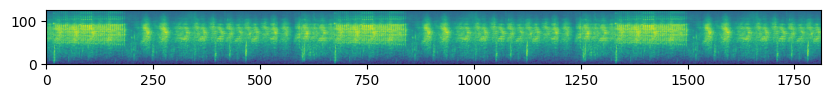

In [18]:
plt.figure(figsize=(10,20))
plt.imshow(batch['image'][0].detach().cpu().numpy(),origin='lower')

In [19]:
from augment import Mixup, Cutmix

In [20]:
x,y = batch['image'].clone(), batch['label'].clone()

In [21]:
x,y = Mixup(1.5)(x,y)
x.shape

torch.Size([128, 128, 1813])

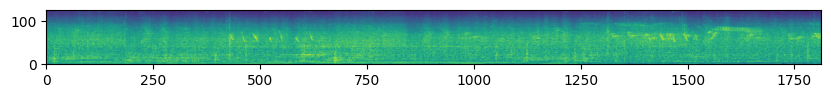

In [22]:
plt.figure(figsize=(10,20))
plt.imshow(x[0].detach().cpu().numpy(),origin='lower')

In [23]:
# y[0]

In [24]:
x,y = batch['image'].clone().unsqueeze(1), batch['label'].clone()

In [25]:
x,y = Cutmix(1.5)(x,y)
x.shape

torch.Size([128, 1, 128, 1813])

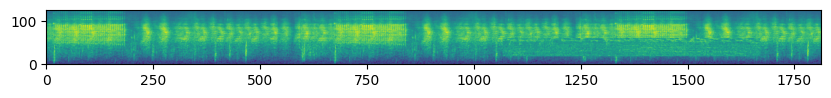

In [26]:
plt.figure(figsize=(10,20))
plt.imshow(x[0][0].detach().cpu().numpy(),origin='lower')

In [27]:
# y[0]

In [28]:
# batch['label'][0]

In [29]:
from torch import nn
import torch
import torch.nn.functional as F
import torch.optim as optim


'''
MetaStyleSpeech style encoder https://arxiv.org/pdf/2106.03153.pdf

Adapted from: https://github.com/keonlee9420/StyleSpeech

'''

import torch
import torch.nn as nn
import numpy as np
from torch.nn import functional as F


class Mish(nn.Module):
    def forward(self, x):
        return x * torch.tanh(F.softplus(x))

class FCBlock(nn.Module):
    """ Fully Connected Block """

    def __init__(self, in_features, out_features, activation=None, bias=False, dropout=None, spectral_norm=False):
        super(FCBlock, self).__init__()
        self.fc_layer = nn.Sequential()
        self.fc_layer.add_module(
            "fc_layer",
            LinearNorm(
                in_features,
                out_features,
                bias,
                spectral_norm,
            ),
        )
        if activation is not None:
            self.fc_layer.add_module("activ", activation)
        self.dropout = dropout

    def forward(self, x):
        x = self.fc_layer(x)
        if self.dropout is not None:
            x = F.dropout(x, self.dropout, self.training)
        return x


class LinearNorm(nn.Module):
    """ LinearNorm Projection """

    def __init__(self, in_features, out_features, bias=False, spectral_norm=False):
        super(LinearNorm, self).__init__()
        self.linear = nn.Linear(in_features, out_features, bias)

        nn.init.xavier_uniform_(self.linear.weight)
        if bias:
            nn.init.constant_(self.linear.bias, 0.0)
        if spectral_norm:
            self.linear = nn.utils.spectral_norm(self.linear)

    def forward(self, x):
        x = self.linear(x)
        return x


class Conv1DBlock(nn.Module):
    """ 1D Convolutional Block """

    def __init__(self, in_channels, out_channels, kernel_size, activation=None, dropout=None, spectral_norm=False):
        super(Conv1DBlock, self).__init__()

        self.conv_layer = nn.Sequential()
        self.conv_layer.add_module(
            "conv_layer",
            ConvNorm(
                in_channels,
                out_channels,
                kernel_size=kernel_size,
                stride=1,
                padding=int((kernel_size - 1) / 2),
                dilation=1,
                w_init_gain="tanh",
                spectral_norm=spectral_norm,
            ),
        )
        if activation is not None:
            self.conv_layer.add_module("activ", activation)
        self.dropout = dropout

    def forward(self, x, mask=None):
        x = x.contiguous().transpose(1, 2)
        x = self.conv_layer(x)

        if self.dropout is not None:
            x = F.dropout(x, self.dropout, self.training)

        x = x.contiguous().transpose(1, 2)
        if mask is not None:
            x = x.masked_fill(mask.unsqueeze(-1), 0)

        return x


class ConvNorm(nn.Module):
    """ 1D Convolution """

    def __init__(
        self,
        in_channels,
        out_channels,
        kernel_size=1,
        stride=1,
        padding=None,
        dilation=1,
        bias=True,
        w_init_gain="linear",
        spectral_norm=False,
    ):
        super(ConvNorm, self).__init__()

        if padding is None:
            assert kernel_size % 2 == 1
            padding = int(dilation * (kernel_size - 1) / 2)

        self.conv = nn.Conv1d(
            in_channels,
            out_channels,
            kernel_size=kernel_size,
            stride=stride,
            padding=padding,
            dilation=dilation,
            bias=bias,
        )
        if spectral_norm:
            self.conv = nn.utils.spectral_norm(self.conv)

    def forward(self, signal):
        conv_signal = self.conv(signal)

        return conv_signal

class MultiHeadAttention(nn.Module):
    """ Multi-Head Attention """

    def __init__(self, n_head, d_model, d_k, d_v, dropout=0.1, layer_norm=False, spectral_norm=False):
        super(MultiHeadAttention, self).__init__()

        self.n_head = n_head
        self.d_k = d_k
        self.d_v = d_v

        self.w_qs = LinearNorm(d_model, n_head * d_k, spectral_norm=spectral_norm)
        self.w_ks = LinearNorm(d_model, n_head * d_k, spectral_norm=spectral_norm)
        self.w_vs = LinearNorm(d_model, n_head * d_v, spectral_norm=spectral_norm)

        self.attention = ScaledDotProductAttention(temperature=np.power(d_k, 0.5))
        self.layer_norm = nn.LayerNorm(d_model) if layer_norm else None

        self.fc = LinearNorm(n_head * d_v, d_model, spectral_norm=spectral_norm)

        self.dropout = nn.Dropout(dropout)

    def forward(self, q, k, v, mask=None):

        d_k, d_v, n_head = self.d_k, self.d_v, self.n_head

        sz_b, len_q, _ = q.size()
        sz_b, len_k, _ = k.size()
        sz_b, len_v, _ = v.size()

        residual = q

        q = self.w_qs(q).view(sz_b, len_q, n_head, d_k)
        k = self.w_ks(k).view(sz_b, len_k, n_head, d_k)
        v = self.w_vs(v).view(sz_b, len_v, n_head, d_v)
        q = q.permute(2, 0, 1, 3).contiguous().view(-1, len_q, d_k)  # (n*b) x lq x dk
        k = k.permute(2, 0, 1, 3).contiguous().view(-1, len_k, d_k)  # (n*b) x lk x dk
        v = v.permute(2, 0, 1, 3).contiguous().view(-1, len_v, d_v)  # (n*b) x lv x dv
        if mask is not None:
            mask = mask.repeat(n_head, 1, 1)  # (n*b) x .. x ..
        output, attn = self.attention(q, k, v, mask=mask)

        output = output.view(n_head, sz_b, len_q, d_v)
        output = (
            output.permute(1, 2, 0, 3).contiguous().view(sz_b, len_q, -1)
        )  # b x lq x (n*dv)

        output = self.dropout(self.fc(output))
        output = output + residual
        if self.layer_norm is not None:
            output = self.layer_norm(output)

        return output, attn


class ScaledDotProductAttention(nn.Module):
    """ Scaled Dot-Product Attention """

    def __init__(self, temperature):
        super(ScaledDotProductAttention, self).__init__()
        self.temperature = temperature
        self.softmax = nn.Softmax(dim=2)

    def forward(self, q, k, v, mask=None):

        attn = torch.bmm(q, k.transpose(1, 2))
        attn = attn / self.temperature

        if mask is not None:
            attn = attn.masked_fill(mask, -1e9)

        attn = self.softmax(attn)
        output = torch.bmm(attn, v)

        return output, attn


class PositionwiseFeedForward(nn.Module):
    """ A two-feed-forward-layer """

    def __init__(self, d_in, d_hid, kernel_size, dropout=0.1):
        super(PositionwiseFeedForward, self).__init__()

        # Use Conv1D
        # position-wise
        self.w_1 = nn.Conv1d(
            d_in,
            d_hid,
            kernel_size=kernel_size[0],
            padding=(kernel_size[0] - 1) // 2,
        )
        # position-wise
        self.w_2 = nn.Conv1d(
            d_hid,
            d_in,
            kernel_size=kernel_size[1],
            padding=(kernel_size[1] - 1) // 2,
        )
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        residual = x
        output = x.transpose(1, 2)
        output = self.w_2(F.relu(self.w_1(output)))
        output = output.transpose(1, 2)
        output = self.dropout(output)
        output = output + residual

        return output
    
def get_mask_from_lengths(lengths):
    max_len = torch.max(lengths).item()
    	
    #print(f'lengths = {lengths}')
    #print(f'max_len = {max_len}')
    
    ids = torch.arange(0, max_len, out=torch.cuda.LongTensor(max_len))
    mask = (ids < lengths.unsqueeze(1)).bool() # (B, max_len)
    return mask


class XCA(nn.Module):
    """ Cross-Covariance Attention (XCA) operation where the channels are updated using a weighted
     sum. The weights are obtained from the (softmax normalized) Cross-covariance
    matrix (Q^T K \\in d_h \\times d_h)
    """

    def __init__(self, dim, num_heads=8, qkv_bias=False, qk_scale=None, attn_drop=0.2, proj_drop=0.2):
        super().__init__()
        self.num_heads = num_heads
        self.temperature = nn.Parameter(torch.ones(num_heads, 1, 1))

        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)

    def forward(self, x):
        B, N, C = x.shape
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, C // self.num_heads)
        qkv = qkv.permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]   # make torchscript happy (cannot use tensor as tuple)

        q = q.transpose(-2, -1)
        k = k.transpose(-2, -1)
        v = v.transpose(-2, -1)

        q = torch.nn.functional.normalize(q, dim=-1)
        k = torch.nn.functional.normalize(k, dim=-1)

        attn = (q @ k.transpose(-2, -1)) * self.temperature
        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)

        x = (attn @ v).permute(0, 3, 1, 2).reshape(B, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)
        return x

    @torch.jit.ignore
    def no_weight_decay(self):
        return {'temperature'}

class XCAMetaBird(nn.Module):
    """ Mel-Style Encoder """

    def __init__(self, num_mel, embedding_dim, num_classes, n_spectral = 2, n_temporal = 2, n_mha = 2, mha_heads = 1, max_seq_len = 400):
        super(XCAMetaBird, self).__init__()
        self.num_classes = num_classes
        # n_position = model_config["max_seq_len"] + 1
        n_mel_channels = num_mel
        d_melencoder = embedding_dim
        n_spectral_layer = n_spectral
        n_temporal_layer = n_temporal
        n_slf_attn_layer = n_mha
        n_slf_attn_head = mha_heads
        d_k = d_v = (
            embedding_dim
            // mha_heads
        )
        kernel_size = 3
        dropout = 0.2

        self.max_seq_len = max_seq_len # This is our default, but it is interesting to be adaptive

        self.fc_1 = FCBlock(n_mel_channels, d_melencoder)

        self.spectral_stack = nn.ModuleList(
            [
                FCBlock(
                    d_melencoder, d_melencoder, activation=Mish()
                )
                for _ in range(n_spectral_layer)
            ]
        )

        
        self.temporal_stack = nn.ModuleList(
            [
                nn.Sequential(
                    Conv1DBlock(
                        d_melencoder, 2 * d_melencoder, kernel_size, activation=Mish(), dropout=dropout
                    ),
                    # nn.AvgPool1d(3, stride=1, padding=1),
                    nn.GLU(),
                )
                for _ in range(n_temporal_layer)
            ]
        )

        self.slf_attn_stack = nn.ModuleList(
            [
                XCA(
                    d_melencoder, n_slf_attn_head
                )
                for _ in range(n_slf_attn_layer)
            ]
        )
        

        self.fc_2 = FCBlock(d_melencoder, d_melencoder)

        self.classifier_layer = nn.Linear(embedding_dim, self.num_classes)
        self.attn = nn.Linear(embedding_dim, 1)
        self.activation = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, mel):
        # mel -> (BS, MEL_DIM, L)
        # print(f'mel shape = {mel.shape}')

        # Tranposing mel input to be (L, MEL_DIM)
        mel = mel.permute(0,2,1) # -> (BS, L, MEL_DIM)

        # Pre-net per frame
        enc_output = self.fc_1(mel) # -> (BS, L, EMB_SIZE)
        # print(f'enc_output shape = {enc_output.shape}')

        # Spectral Processing per frame
        for _, layer in enumerate(self.spectral_stack):
            enc_output = layer(enc_output) # -> (BS, L, EMB_SIZE)
        # print(f'after spectral process shape = {enc_output.shape}')


        # Temporal Processing (only per frame to get temporal patterns)
        for _, layer in enumerate(self.temporal_stack):
            residual = enc_output
            enc_output = layer(enc_output)
            enc_output = residual + enc_output # -> (BS, L, EMB_SIZE)

        # print(f'after temporal process shape = {enc_output.shape}')
        
        # Multi-head self-attention per frame
        for _, layer in enumerate(self.slf_attn_stack):
            residual = enc_output
            enc_output = layer(
                enc_output
            )
            enc_output = residual + enc_output # -> (BS, L, EMB_SIZE)
        # print(f'after mha process shape = {enc_output.shape}')
        
        # Post-net for frames and frequency
        enc_output = self.fc_2(self.activation(enc_output)) # -> (BS, L, EMB_SIZE)


        attn_weights = F.softmax(self.attn(enc_output), dim=1) # -> (BS, 2, 1)
        # print(attn_weights.shape)
        enc_output = torch.sum(enc_output * attn_weights, dim=1) # -> (BS, EMB_SIZE)
        
        pred = self.classifier_layer(self.dropout(enc_output)) # -> (BS, NUM_CLASSES)

        return pred

In [30]:
n = XCAMetaBird(128,512,335).cuda()

x = torch.rand((1,128,469))
y = torch.randint(low=0, high=335, size=(1,1))[0]

pred = n(x.cuda())
pred.shape

torch.Size([1, 335])

In [31]:
del n

In [32]:
# from torchvision.models import efficientnet

In [33]:
# class EffNet(nn.Module):
    
#     def __init__(self, n_classes, pretrained=True):
#         super().__init__()
        
#         weights = efficientnet.EfficientNet_B0_Weights.DEFAULT

#         self.base_model = efficientnet.efficientnet_b0(weights=weights)

#         self.base_model.classifier[1] = nn.Linear(self.base_model.classifier[1].in_features, n_classes, dtype=torch.float32)
    
#     def forward(self, x):
#         # x = x.unsqueeze(-1)
#         # x = torch.cat([x, x, x], dim=3).permute(0, 3, 1, 2)
#         x = x.unsqueeze(1)
#         x = x.expand(-1, 3, -1, -1)
#         return self.base_model(x)

In [34]:
# n = EffNet(335).cuda()

# x = torch.rand((1,128,137))
# y = torch.randint(low=0, high=335, size=(1,1))[0]

# pred = n(x.cuda())
# pred.shape

In [35]:
# del n

In [81]:
def check_update(model, grad_clip, ignore_stopnet=False, amp_opt_params=None):
    r"""Check model gradient against unexpected jumps and failures"""
    skip_flag = False
    if ignore_stopnet:
        if not amp_opt_params:
            grad_norm = torch.nn.utils.clip_grad_norm_(
                [param for name, param in model.named_parameters() if "stopnet" not in name], grad_clip
            )
        else:
            grad_norm = torch.nn.utils.clip_grad_norm_(amp_opt_params, grad_clip)
    else:
        if not amp_opt_params:
            grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
        else:
            grad_norm = torch.nn.utils.clip_grad_norm_(amp_opt_params, grad_clip)

    # compatibility with different torch versions
    if isinstance(grad_norm, float):
        if np.isinf(grad_norm):
            print(" | > Gradient is INF !!")
            skip_flag = True
    else:
        if torch.isinf(grad_norm):
            print(" | > Gradient is INF !!")
            skip_flag = True
    return grad_norm, skip_flag

def evaluation(model, criterion, data_loader, global_step):
    eval_loss = 0
    ang_loss = 0
    ce_loss = 0
    
    acc_ = 0
    for _, data in enumerate(data_loader):
        with torch.no_grad():
            # setup input data
            inputs, labels = data['image'], data['label']

#             print(labels.shape)
#             print(labels.view(eval_num_utter_per_class, eval_num_classes_in_batch).shape)
            
            # agroup samples of each class in the batch. perfect sampler produces [3,2,1,3,2,1] we need [3,3,2,2,1,1]
            # labels = torch.transpose(
            #     labels.view(eval_num_utter_per_class, eval_num_classes_in_batch), 0, 1
            # ).reshape(labels.shape)
            # inputs = torch.transpose(
            #     inputs.view(eval_num_utter_per_class, eval_num_classes_in_batch, -1), 0, 1
            # ).reshape(inputs.shape)

            # dispatch data to GPU
            if use_cuda:
                inputs = inputs.cuda(non_blocking=True)
                labels = labels.cuda(non_blocking=True)

            # forward pass model
            pred = model(inputs)

            loss = criterion(pred,labels)
            
#             print(pred.argmax(axis = -1).cpu().numpy())
            acc_ += (pred.argmax(axis = -1).cpu().numpy() == labels.argmax(-1).cpu().numpy()).sum()/len(labels)
            
            eval_loss += loss.item()

            # ang_loss += loss.item()
            ce_loss += loss.item()
            
    eval_avg_loss = eval_loss / len(data_loader)
    # eval_avg_angloss = ang_loss / len(data_loader)
    eval_avg_celoss = ce_loss / len(data_loader)
    
#     print(acc_, len(data_loader), _)
    acc = acc_/len(data_loader)
    
    print(f"Evaluation accuracy = {acc}")
    # # save stats
    # dashboard_logger.eval_stats(global_step, {"loss": eval_avg_loss})
    # # plot the last batch in the evaluation
    # figures = {
    #     "UMAP Plot": plot_embeddings(outputs.detach().cpu().numpy(), c.num_classes_in_batch),
    # }
    # dashboard_logger.eval_figures(global_step, figures)
    return eval_avg_loss, eval_avg_celoss, acc



import time
def train(model, optimizer, scheduler, criterion, criterion2, data_loader, eval_data_loader, global_step):
    model.train()
    best_loss = float("inf")

    # Defining mixup and cutmix
    # mixup
    mup = Mixup(1.5)
    #cutmix
    cmix = Cutmix(1.5)
    
    print('START training')
    # best_loss = {"train_loss": None, "eval_loss": float("inf")}
    avg_loader_time = 0
    end_time = time.time()
    total_steps = 0
    for epoch in range(epochs):
        tot_loss = 0
        epoch_time = 0
        for _, data in enumerate(data_loader):
            start_time = time.time()

            # setup input data
            inputs, labels = data['image'], data['label']
            
            # agroup samples of each class in the batch. perfect sampler produces [3,2,1,3,2,1] we need [3,3,2,2,1,1]
            # labels = torch.transpose(labels.view(num_utter_per_class, num_classes_in_batch), 0, 1).reshape(
                # labels.shape
            # )
            # inputs = torch.transpose(inputs.view(num_utter_per_class, num_classes_in_batch, -1), 0, 1).reshape(
                # inputs.shape
            # )

            loader_time = time.time() - end_time
            global_step += 1

            # print(loader_time)

            # dispatch data to GPU
            if use_cuda:
                inputs = inputs.cuda(non_blocking=True)
                labels = labels.cuda(non_blocking=True)

            if(epoch>10):
                if(random.uniform(0, 1) > 0.2):
                    for _ in range(n_mup):
                        inputs, labels = mup(inputs, labels)
                        
                if(random.uniform(0, 1) > 0.5):
                    for _ in range(n_cmix):
                        inputs, labels = cmix(inputs.unsqueeze(1), labels)
                        inputs = inputs.squeeze(1)
            
            # forward pass model
            pred = model(inputs)
            # print(pred.shape, labels.shape, labels.min(), labels.max())

#             print(outputs.shape)
#             print(outputs.view(num_classes_in_batch, outputs.shape[0] // num_classes_in_batch, -1).shape)
#             loss computation
            if(epoch > 10):
                loss = criterion(pred, labels)
            else:
                loss = criterion2(pred,labels.argmax(-1))
            # print(labels.argmax(-1))
            # if total_steps > 50:
            #     # loss = criterion1(
            #     #     outputs.view(num_classes_in_batch, outputs.shape[0] // num_classes_in_batch, -1), labels
            #     # )
            #     loss2 = criterion2(pred, labels)

            #     loss = loss*0.5 + loss2*0.5
                
            # else:
            #     loss2 = criterion2(pred, labels)

            #     loss = loss2
                
                
            loss.backward()
            grad_norm, _ = check_update(model, grad_clip)
            optimizer.step()


            # # setup lr
            if scheduler is not None:
                scheduler.step(epoch + _/len(data_loader))
                # scheduler.step()
            optimizer.zero_grad()

            
            total_steps += 1
            
            step_time = time.time() - start_time
            epoch_time += step_time

            # acumulate the total epoch loss
            tot_loss += loss.item()

            # Averaged Loader Time
            # num_loader_workers = num_loader_workers if c.num_loader_workers > 0 else 1
            avg_loader_time = (
                1 / num_loader_workers * loader_time + (num_loader_workers - 1) / num_loader_workers * avg_loader_time
                if avg_loader_time != 0
                else loader_time
            )
            current_lr = optimizer.param_groups[0]["lr"]


            if global_step % print_step == 0:
                print(
                    "   | > Step:{}  Loss:{:.5f}  GradNorm:{:.5f}  "
                    "StepTime:{:.2f}  LoaderTime:{:.2f}  AvGLoaderTime:{:.2f}  LR:{:.6f}".format(
                        global_step, loss.item(), grad_norm, step_time, loader_time, avg_loader_time, current_lr
                    ),
                    flush=True,
                )

            if global_step % save_step == 0:
                # save model
                # save_checkpoint(
                #     c, model, optimizer, None, global_step, epoch, OUT_PATH, criterion=criterion.state_dict()
                # )
                print("Saving iteration model")
                torch.save(model.state_dict(), f'{save_path}/checkpoint_{global_step}.pth')

            end_time = time.time()

        print("")
        print(
            ">>> Epoch:{}  AvgLoss: {:.5f} GradNorm:{:.5f}  "
            "EpochTime:{:.2f} AvGLoaderTime:{:.2f} ".format(
                epoch, tot_loss / len(data_loader), grad_norm, epoch_time, avg_loader_time
            ),
            flush=True,
        )
        # evaluation
        if run_eval:
            model.eval()
            eval_loss, ce_loss, acc = evaluation(model, criterion, eval_data_loader, global_step)
            print("\n\n")
            print("--> EVAL PERFORMANCE")
            print(
                "   | > Epoch:{}  AvgLoss: {:.5f} CELoss {:.5f}".format(epoch, eval_loss, ce_loss),
                flush=True,
            )
            
            # If reduce on plateau
            # scheduler.step(eval_loss)
                
            if(eval_loss < best_loss):
                print("Saving best model")
                acc = int(100*acc)
                torch.save(model.state_dict(), f'{save_path}/best_model_{global_step}_{acc}.pth')
                best_loss = eval_loss
            # save the best checkpoint
            # best_loss = save_best_model(
            #     {"train_loss": None, "eval_loss": eval_loss},
            #     best_loss,
            #     c,
            #     model,
            #     optimizer,
            #     None,
            #     global_step,
            #     epoch,
            #     OUT_PATH,
            #     criterion=criterion.state_dict(),
            # )
            model.train()

    return best_loss, global_step


In [82]:
# random.uniform(0, 1)

In [83]:
## Also defining global constants
num_loader_workers = 1
grad_clip = 3

print_step = 1000
save_step = 10000
epochs = 100
lr_decay = 0

save_path = './pre_trained_weights/xca_128emb_pastcompetition_mixup_cutmix'

run_eval = True

model = XCAMetaBird(128,128,734)

# Number of mixups and cutmix
n_cmix = 1
n_mup = 2

optimizer = optim.AdamW(model.parameters(), lr=1e-3, betas=(0.9, 0.999), eps=1e-8, weight_decay = 1e-3)
# optimizer = optim.RAdam(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-8, weight_decay = 1e-4)
criterion = nn.BCEWithLogitsLoss()
criterion2 = nn.CrossEntropyLoss()
# criterion2 = None
scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0 = 30, T_mult = 2, eta_min=1e-6, last_epoch = -1)

global_step = 0
use_cuda = True

train_dataset = BasicDataset(df_train, lazy_load=True)
val_dataset = BasicDataset(df_val, lazy_load=True)

train_dataloader = DataLoader(train_dataset, 
                              batch_size=32, 
                              shuffle=True, 
                              # num_workers=num_loader_workers, 
                              pin_memory=True)  
                              # persistent_workers=True)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=False, 
                            # num_workers=num_loader_workers, 
                            pin_memory= True)
                            # persistent_workers=True)

if use_cuda:
    model.cuda()
    criterion.cuda()

In [84]:
sum(p.numel() for p in model.parameters() if p.requires_grad)

488801

In [85]:
torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark = True
torch.manual_seed(54321)

_, global_step = train(model, optimizer, scheduler, criterion, criterion2, train_dataloader, val_dataloader, global_step)

START training
   | > Step:1000  Loss:5.44354  GradNorm:2.63127  StepTime:0.09  LoaderTime:0.03  AvGLoaderTime:0.03  LR:0.001000
   | > Step:2000  Loss:4.67131  GradNorm:3.71149  StepTime:0.09  LoaderTime:0.03  AvGLoaderTime:0.03  LR:0.001000

>>> Epoch:0  AvgLoss: 5.42637 GradNorm:4.02880  EpochTime:237.16 AvGLoaderTime:0.03 
Evaluation accuracy = 0.11997767857142858



--> EVAL PERFORMANCE
   | > Epoch:0  AvgLoss: 0.67868 CELoss 0.67868
Saving best model
   | > Step:3000  Loss:4.70293  GradNorm:5.87069  StepTime:0.09  LoaderTime:0.03  AvGLoaderTime:0.03  LR:0.000997
   | > Step:4000  Loss:4.08002  GradNorm:4.65589  StepTime:0.09  LoaderTime:0.03  AvGLoaderTime:0.03  LR:0.000997
   | > Step:5000  Loss:4.85157  GradNorm:5.49632  StepTime:0.09  LoaderTime:0.03  AvGLoaderTime:0.03  LR:0.000997

>>> Epoch:1  AvgLoss: 4.32332 GradNorm:5.46427  EpochTime:235.32 AvGLoaderTime:0.04 
Evaluation accuracy = 0.2044642857142857



--> EVAL PERFORMANCE
   | > Epoch:1  AvgLoss: 0.84717 CELoss 0.8471

KeyboardInterrupt: 

In [ ]:
# First 10 epochs with CE last 90 with BCE